In [1]:
#%%capture

import pandas as pd
import numpy as np
import scipy as sp
import plotly
import folium
import os

import plotly.io as pio
pio.renderers.default='notebook'

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets
from IPython.core.display import HTML
from IPython.display import display, clear_output
import datetime
from io import StringIO


import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import trianer

plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
races_configs = trianer.Race.load_races_configs()

In [3]:
athlete = trianer.Athlete(
        name="John Doe",
        config={
"swimming_sX100m":datetime.time(2, 35),
"cycling_kmXh":30,
"running_sXkm":datetime.time(5, 30),
"transition_swi2cyc_s":datetime.time(2, 0),
"transition_cyc2run_s":datetime.time(2, 0),
"weight_kg":70
},
    )
simulation = trianer.Triathlon(epreuve="Elsassman (L)", races_configs=races_configs, athlete=athlete, info_box=None)

2022-09-18 21:23:05.698 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            
2022-09-18 21:23:05.701 Initialized tornado logs
2022-09-18 21:23:05.702 
  command:

    streamlit run /opt/miniconda/envs/trianer_py3.10/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


['swimming', 'cycling', 'running']


In [4]:
# Dataframe to models
df_model_properties = pd.DataFrame({
    'Model':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all'],    
    'Features': [['t'],['t'],['t'],['t'],['t','h'],
                 ['t','h'],['t','h'],['t','h','T'],
                 ['t','h','T'],['t','h','T','A','W','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H']],
    'Regressors':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all']
}).set_index('Model')

display(df_model_properties)

for f in ['MAE_test', 'R2_test', 'MAE_train', 'R2_train']:
    df_model_properties[f] = ""
    

,Features,Regressors
Model,,
linear_t,[t],linear_t
quad_t,[t],quad_t
SPPM_t,[t],SPPM_t
DPPM_t,[t],DPPM_t
multlin_th,"[t, h]",multlin_th
multquad_th,"[t, h]",multquad_th
power_th,"[t, h]",power_th
multlin_tht,"[t, h, T]",multlin_tht
multquad_tht,"[t, h, T]",multquad_tht


In [6]:
# Import Calories Dataset
df_cal = pd.read_csv('kkcalories/calories.csv')

# Import Exercises Dataset
df_ex  = pd.read_csv('kkcalories/exercise.csv')

# Merging Datasets
df = pd.merge(df_ex, df_cal, on = 'User_ID')
df.head()

# Convert string to int
df['Gender'] = pd.get_dummies(df['Gender'], prefix_sep='_', drop_first=True)
df = df.drop(columns=['User_ID'], axis=1)

display(df.head())

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["Calories"]), df["Calories"], test_size=0.3)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0


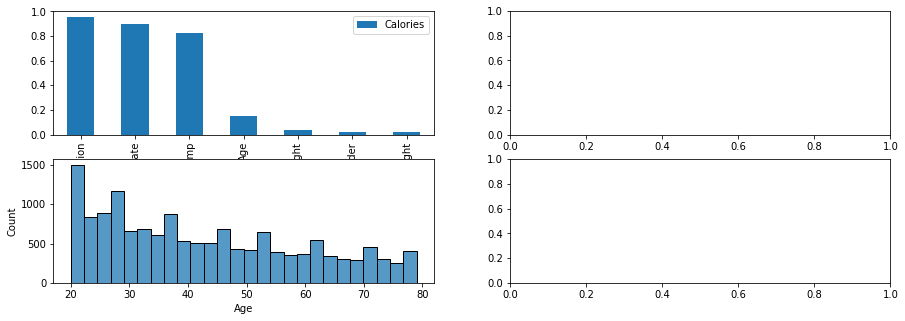

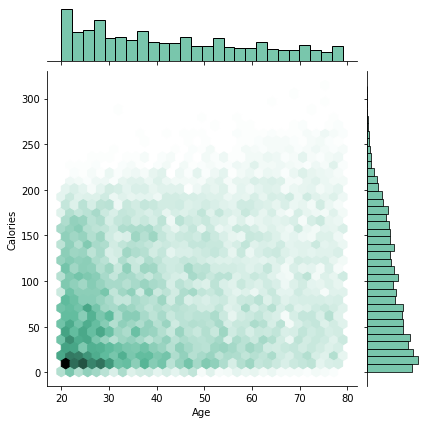

In [7]:
correlations = df.copy().corr()['Calories']
correlations = correlations.sort_values(ascending=False).drop('Calories', axis=0)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=2)

correlations.to_frame().plot.bar(ax=ax[0][0]);
sns.histplot(df['Age'], ax=ax[1][0])
#sns.displot(x='Gender', y='Calories', data=df, ax=ax[0][1]);

sns.jointplot(x='Age', y='Calories', data=df, kind="hex", color="#4CB391")

From here, it is possible to see that the features that most contribute to the total calory burned on exercises is the 'duration', the 'heart rate' and the 'body temperature'

Let's rename the variables as:

t  : Duration
h  : Heart_Rate
T  : Body_Temp
A  : Age
W  : Weight
G  : Gender
H  : Height
C  : Calories

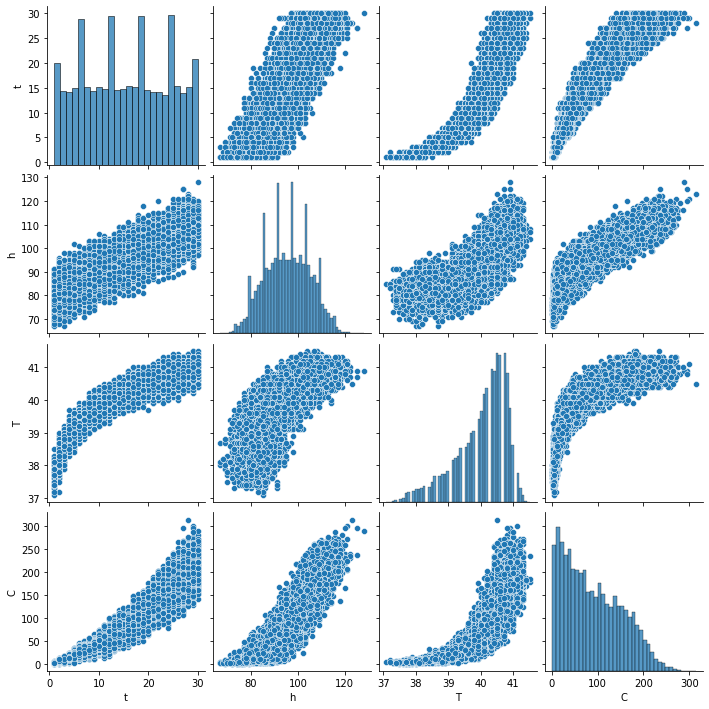

In [8]:
df_3f = df[['Duration','Heart_Rate','Body_Temp','Calories']].copy()
df_3f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Calories':'C'},inplace=True)


df_6f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Height','Calories']].copy()
df_6f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Height':'H',
                      'Calories':'C'},inplace=True)


df_7f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Gender','Height','Calories']].copy()
df_7f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

sns.pairplot(df_3f)

From the scatter graphics, it's possible to conclude that, despite the strong correlation between the variables  t  and  C , the relation between them is not trivially linear. It's possible that a quadratic regression approach can substantially reduce the errors. Another way to deal with this problem is with power law models. To do this, let's check the relation betweeen logs of variables.

## One Feature Regression

### Linear Model
### Quadratic Model
### Power Law Models
### Model Comparison

As a first step, let's calculate the regression relating Calories and Duration, that are the most correlated variables.

In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train, y_train, task="regression",metric='rmse', time_budget=300)

[flaml.automl: 09-18 21:24:28] {2600} INFO - task = regression
2022-09-18 21:24:28.126 task = regression
[flaml.automl: 09-18 21:24:28] {2602} INFO - Data split method: uniform
2022-09-18 21:24:28.128 Data split method: uniform
[flaml.automl: 09-18 21:24:28] {2605} INFO - Evaluation method: cv
2022-09-18 21:24:28.130 Evaluation method: cv
[flaml.automl: 09-18 21:24:28] {2727} INFO - Minimizing error metric: rmse
2022-09-18 21:24:28.136 Minimizing error metric: rmse
[flaml.automl: 09-18 21:24:28] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
2022-09-18 21:24:28.140 List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 09-18 21:24:28] {3174} INFO - iteration 0, current learner lgbm
2022-09-18 21:24:28.142 iteration 0, current learner lgbm
[flaml.automl: 09-18 21:24:28] {3307} INFO - Estimated sufficient time budget=960s. Estimated necessary time budget=7s.
2022-09-18 21:24:2

[flaml.automl: 09-18 21:24:31] {3174} INFO - iteration 19, current learner rf
2022-09-18 21:24:31.180 iteration 19, current learner rf
[flaml.automl: 09-18 21:24:31] {3354} INFO -  at 3.2s,	estimator rf's best error=13.2575,	best estimator lgbm's best error=2.4787
2022-09-18 21:24:31.344  at 3.2s,	estimator rf's best error=13.2575,	best estimator lgbm's best error=2.4787
[flaml.automl: 09-18 21:24:31] {3174} INFO - iteration 20, current learner rf
2022-09-18 21:24:31.345 iteration 20, current learner rf
[flaml.automl: 09-18 21:24:31] {3354} INFO -  at 3.5s,	estimator rf's best error=9.0745,	best estimator lgbm's best error=2.4787
2022-09-18 21:24:31.598  at 3.5s,	estimator rf's best error=9.0745,	best estimator lgbm's best error=2.4787
[flaml.automl: 09-18 21:24:31] {3174} INFO - iteration 21, current learner rf
2022-09-18 21:24:31.599 iteration 21, current learner rf
[flaml.automl: 09-18 21:24:31] {3354} INFO -  at 3.8s,	estimator rf's best error=6.4268,	best estimator lgbm's best err

2022-09-18 21:24:37.676 iteration 40, current learner xgboost
[flaml.automl: 09-18 21:24:38] {3354} INFO -  at 9.9s,	estimator xgboost's best error=15.6283,	best estimator lgbm's best error=2.4787
2022-09-18 21:24:38.009  at 9.9s,	estimator xgboost's best error=15.6283,	best estimator lgbm's best error=2.4787
[flaml.automl: 09-18 21:24:38] {3174} INFO - iteration 41, current learner xgboost
2022-09-18 21:24:38.011 iteration 41, current learner xgboost
[flaml.automl: 09-18 21:24:38] {3354} INFO -  at 10.3s,	estimator xgboost's best error=10.2974,	best estimator lgbm's best error=2.4787
2022-09-18 21:24:38.429  at 10.3s,	estimator xgboost's best error=10.2974,	best estimator lgbm's best error=2.4787
[flaml.automl: 09-18 21:24:38] {3174} INFO - iteration 42, current learner lgbm
2022-09-18 21:24:38.431 iteration 42, current learner lgbm
[flaml.automl: 09-18 21:24:39] {3354} INFO -  at 10.9s,	estimator lgbm's best error=2.4787,	best estimator lgbm's best error=2.4787
2022-09-18 21:24:39.02

[flaml.automl: 09-18 21:24:52] {3354} INFO -  at 24.8s,	estimator lgbm's best error=1.9167,	best estimator lgbm's best error=1.9167
2022-09-18 21:24:52.926  at 24.8s,	estimator lgbm's best error=1.9167,	best estimator lgbm's best error=1.9167
[flaml.automl: 09-18 21:24:52] {3174} INFO - iteration 62, current learner xgboost
2022-09-18 21:24:52.927 iteration 62, current learner xgboost
[flaml.automl: 09-18 21:24:53] {3354} INFO -  at 25.3s,	estimator xgboost's best error=4.0276,	best estimator lgbm's best error=1.9167
2022-09-18 21:24:53.352  at 25.3s,	estimator xgboost's best error=4.0276,	best estimator lgbm's best error=1.9167
[flaml.automl: 09-18 21:24:53] {3174} INFO - iteration 63, current learner xgboost
2022-09-18 21:24:53.353 iteration 63, current learner xgboost
[flaml.automl: 09-18 21:24:54] {3354} INFO -  at 26.7s,	estimator xgboost's best error=4.0276,	best estimator lgbm's best error=1.9167
2022-09-18 21:24:54.754  at 26.7s,	estimator xgboost's best error=4.0276,	best esti

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

regressors = [linear_model.LinearRegression(), 
              RandomForestRegressor(n_estimators=30, random_state=42), 
              DecisionTreeRegressor(random_state=42), XGBRegressor()]

plt.figure(figsize=(10, 5))
plt.scatter(df['Duration'], df['Calories'],c='lightgray',label = 'observations',alpha = 0.6, marker='.',zorder=1)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

for reg in regressors:
    # Create a lineat regression object
    # reg = linear_model.LinearRegression()

    # Train the model using the training sets
    reg.fit(x_train, y_train)

    # Predictions for the test set
    p_test, p_train = reg.predict(x_test), reg.predict(x_train)

    mae_test = mean_absolute_error(y_test, p_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, p_test))
    r2s_test = r2_score(y_test, p_test)
    
    mae_train = mean_absolute_error(y_train, p_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, p_train))
    r2s_train = r2_score(y_train, p_train)
    
    # Printing  results
    print(f'{type(reg)} me (test): {mae_test:.3f}, R2 (test):  {r2s_test:.3f}, RMSE (test):  {rmse_test:.3f}')
    print(f'{type(reg)} me (train): {mae_train:.3f}, R2 (train):  {r2s_train:.3f}, RMSE (train):  {rmse_train:.3f}')

    # Plotting and comparing
    #plt.plot(np.linspace(t_i.min(), t_i.max(), 100), reg.predict(t_val.reshape(-1,1)), c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)


In [ ]:
corr_matrix = df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) 
sns.heatmap(corr_matrix, annot=False ,cmap=cmap)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scl = MinMaxScaler(feature_range = (0, 1))
X = scl.fit_transform(X)
X


In [ ]:
plt.style.use(['dark_background'])
fig = plt.figure(figsize=(10, 5),facecolor='b', edgecolor='g')
plt.scatter(y_test,p_test ,s=10,c='g',label='Predicted') 
plt.plot(y_test, y_test,'white' ,label='Test' ,linewidth=2.0)
plt.legend(fontsize=20)
plt.show()

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, p_test))  
print('MSE:', metrics.mean_squared_error(y_test, p_test))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, p_test)))
print('VarScore:',metrics.explained_variance_score(y_test,p_test))

score = reg.score(x_train, y_train)
percentage = "{:.0%}".format(score)

print('Acc_Score:',percentage)

In [ ]:
data = trianer.get_kcalories(None)
data["discipline_speed"] = data["discipline"] + "_" + data["speed"].astype(str)
data2 = data[["discipline_speed", "X kg"]].sort_values("X kg", ascending=False)

fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Bar(x=data2['discipline_speed'],y=data2['X kg'],name=""),secondary_y=False,)
fig.update_layout(autosize=False,width=1200,height=800,title_text="Activity and Calories per kg")
fig.update_xaxes(title_text="Activity")
fig.update_yaxes(title_text="calory",secondary_y=False)
fig.show()

In [ ]:
trianer.hist_calories_per_sport()

In [ ]:
trianer.wordcloud_calories_per_sport()

In [ ]:
from os import path
from PIL import Image
import random as rd

from wordcloud import WordCloud, STOPWORDS

data = trianer.get_kcalories(None)

ddata = data.groupby("discipline").mean()
w = np.round(10 * ddata["X kg"] / ddata["X kg"].max())

words = []
for d in ddata.index:
    words += [d] * int(w[d])

rd.shuffle(words)

# read the mask image
alice_mask = np.array(Image.open("vetruve.png"))

plt.figure(figsize=(15,10))

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask, contour_width=0, contour_color='#f5f4f2', 
               repeat=True, min_font_size=1, colormap="gist_ncar")
#wc = WordCloud(background_color='white', width=750, height=500)


# generate word cloud
wc.generate(" ".join(words))
wc.to_file("vetruve_gen.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()